<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">

<div style=" padding: 10px; font-size: 34px; text-align: center;">
<strong>Uma Fera mais profunda (com camadas...)</strong> 


<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autor:</strong> Ana Luz Pereira Mendes, Caio Matheus Leão Dantas
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> Daniel R. Cassar

## **INTRODUÇÃO**

Para montar uma rede neural convolucional (CNN), o primeiro passo é entender que ela é composta por diferentes tipos de camadas, geralmente organizadas em blocos convolucionais seguidos por camadas densas (fully connected). Observe a imgem a  baixo para entender a organização de uma CNN.\
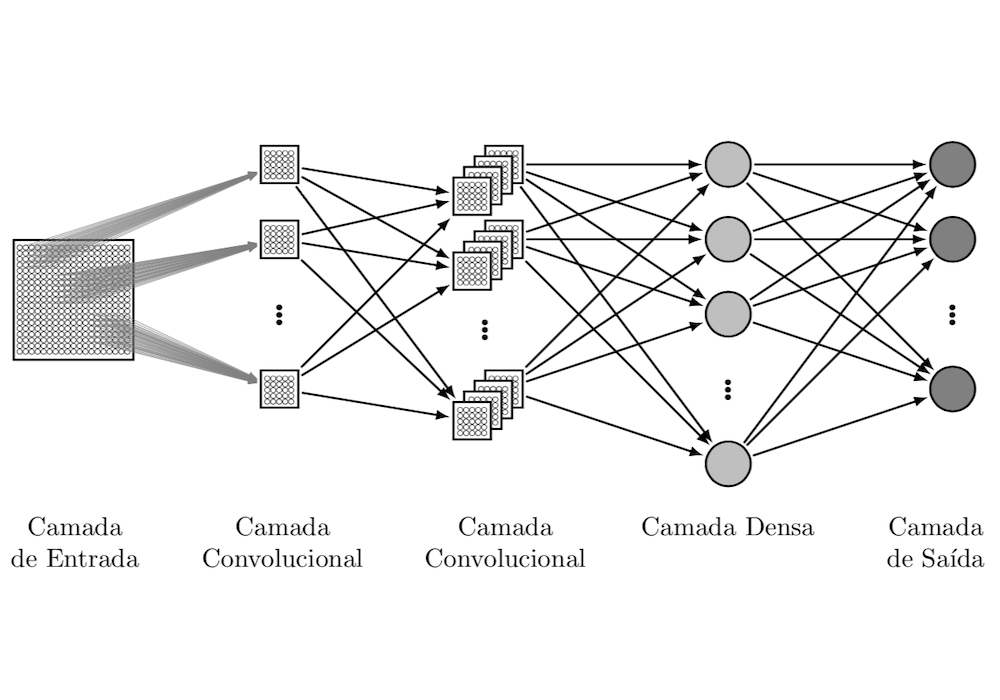

Fonte da Imagem: https://www.sakurai.dev.br/cnn-mapreduce/

---

## **CÓDIGOS**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

ModuleNotFoundError: No module named 'torch._C'

As camadas convolucionais de uma CNN extraem padrões da imagem usando filtros (ou *kernels*), aplicados com *nn.Conv2d*. No primeiro bloco, uma imagem em escala de cinza passa por 32 filtros 5×5, gerando 32 mapas de ativação. Em seguida, aplicam-se a função de ativação ReLU (*nn.ReLU()*) e o MaxPooling (*nn.MaxPool2d(kernel_size=2)*), que reduz a dimensão da imagem.


Na segunda camada convolucional, o processo se repete com 64 filtros, agora recebendo como entrada os 32 mapas anteriores. Após nova aplicação de ReLU e MaxPooling, a saída é achatada (*flatten*) e passada para uma camada densa com 1000 neurônios (*nn.Linear + ReLU*).


Por fim, a camada de saída (*nn.Linear*) gera as predições finais — por exemplo, 10 valores representando as probabilidades de cada classe.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU())
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instancia o Model()
modelo = MyCNN()

print(modelo)

MyCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


Agora podemos baixar os dados, dividi-los e trasnforma-los.

In [ ]:
# Pequena transformação para tensores e normalizando o tamanho
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Train/Test Datasets
data_treino = datasets.MNIST(root='./data', train=True, transform=trans, download=True)
data_teste = datasets.MNIST(root='./data', train=False, transform=trans, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 63.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.49MB/s]


In [ ]:
data_treino, data_teste

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

Nessa etapa vamos dividir nossos dados em lotes para que seja mais fácil convergir os pesos. Observe também que, nesse passo, usamos o *shuffle = True* para embaralhar os dados, fazendo que o modelo não seja influenciado pela ordem dos dados.

In [ ]:
batch_size = 32 #tamanho do lote

train_loader = DataLoader(data_treino, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_teste, batch_size=batch_size, shuffle=False)

São quase 3 milhões e 200 mil parâmetros, como pode ser visto abaixo, então seria meio loucura fazer isso numa CPU e torcer para dar certo!!!

In [ ]:
def count_parameters(modelo):
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)

count_parameters(modelo)

3199106

Com isso, para nossa sorte, o próprio Google Colab disponibiliza uma GPU de graça. Com isso, como não somos bobos (só um pouco), vamos utilizá-la para facilitar o nosso processo de treino e teste.

O nome e comprovação da GPU pode ser vista abaixo:

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
modelo = MyCNN()
funcao_de_perda = nn.CrossEntropyLoss()
TAXA_DE_APRENDIZADO = 1e-3
EPOCAS = 5

Otimizamos pelo otimizador Adam, que funciona, basicamente, a partir dos conceitos de momento - mais especificamente, dois momentos: um sendo a média dos gradientes passados e outro a média dos quadrados dos gradientes passados, que gera uma aprendizagem adaptativa.

###### \* O funcionamento na teoria do otimizador em si pode ser visto de forma mais detalhado nas referências [5] e [6] desse notebook

In [ ]:
otimizador = torch.optim.Adam(modelo.parameters(), lr=TAXA_DE_APRENDIZADO)

Por fim, realizamos o treinamento do modelo

In [ ]:
# Loop de treino
for epoca in range(EPOCAS):
    modelo.train()
    perda = 0
    lista_acuracia = []

    for (images, labels) in train_loader: ### para cada batch
        outputs = modelo(images)

        # --------
        # Cálculo da perda baseada na função de perda
        # --------
        loss = funcao_de_perda(outputs, labels)

        # --------
        # Realização do Backpropagation e otimização com o Adam
        # --------
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()

        perda += loss.item()

        # --------
        # Para cálculo da acurácia
        # --------
        total = labels.size(0)
        _, preditos = torch.max(outputs.data, 1) # pega o valor mais alto das probabilidades das 10 classes possíveis.
        correto = (preditos == labels).sum().item() # somar o número de acertos
        lista_acuracia.append(correto / total)

    perda_media = perda / len(train_loader) #soma das perdas de todos os batches da época/ número de batches
    acuracia_media = sum(lista_acuracia) / len(lista_acuracia)#soma todas as acurácias dos batches/número de batches
    print(f"Época [{epoca+1}/{EPOCAS}], Perda média: {perda_media:.4f}, Acuràcia média: {acuracia_media:.4f}")

Época [1/5], Perda média: 0.1031, Acuràcia média: 0.9678
Época [2/5], Perda média: 0.0403, Acuràcia média: 0.9876
Época [3/5], Perda média: 0.0269, Acuràcia média: 0.9916
Época [4/5], Perda média: 0.0209, Acuràcia média: 0.9933
Época [5/5], Perda média: 0.0150, Acuràcia média: 0.9953


In [ ]:
modelo.eval()

image, label = data_teste[0]
image_single = image.unsqueeze(0) ### dá dimensão ao batch

with torch.no_grad():

    output_single = modelo(image_single)
    _, predito_single = torch.max(output_single.data, 1)
    predito_item = predito_single.item()

    correto = 0
    total = 0
    for images, labels in test_loader:
        outputs = modelo(images)

        # gera predições usando a função max()
        _, predito = torch.max(outputs.data, 1)

        # --------
        # Acumula a quantidade de totais e corretos
        # --------

        total += labels.size(0)
        correto += (predito == labels).sum().item()

    print(f"Acurácia do Modelo em 10k imagens de teste: {round((correto / total) * 100, 3)}")

Acurácia do Modelo em 10k imagens de teste: 99.29


Comparação entre uma das previsões do modelo e seu valor de imagem real

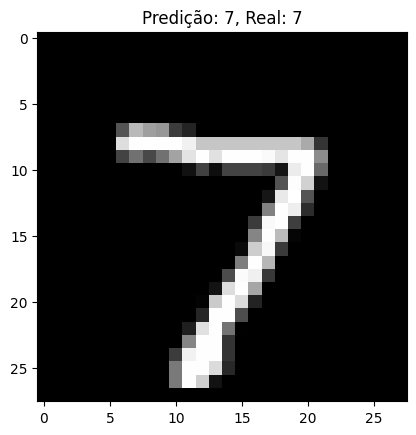

In [ ]:
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Predição: {predito_item}, Real: {label}")
plt.show()

---

## **CONCLUSÃO**

As principais diferenças entre uma rede neural tradicional e uma CNN estão na estrutura e na eficiência no processamento de imagens. As redes tradicionais utilizam camadas totalmente conectadas, onde cada neurônio está ligado a todos os outros, enquanto as CNNs empregam camadas convolucionais, que lidam com os dados de forma hierárquica, identificando padrões em diferentes níveis de complexidade. Além disso, as CNNs são especificamente projetadas para processar imagens e dados espaciais, aproveitando a estrutura espacial dos dados, enquanto as redes tradicionais não têm essa especialização.

---

## **REFERÊNCIAS**

**[1]** CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. Material de Aula.

**[2]** Redes Neurais Convolucionais com PyTorch. Google Colab. 2021. Disponível em: https://colab.research.google.com/github/storopoli/ciencia-de-dados/blob/main/notebooks/Aula_19_Redes_Neurais_Convolucionais_com_PyTorch.ipynb#scrollTo=C1h7rddsOezr.

**[3]** LARANJEIRA, Camila. CNN: Redes Neurais Convolucionais - Deep Learning com PyTorch. ALURA.  Disponível em: https://www.alura.com.br/conteudo/cnn-redes-neurais-convolucionais-deep-learning-pytorch?srsltid=AfmBOopUErsDHpw-s7o_4kQOqExfZ_Nyt_QxdeEd6BEf5DQIUCli9Q6L.

**[4]** SELECTSTAR. What is MNIST and Why is it Important?. Medium. 2020. Disponível em: https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5.

**[5]** KINGMA, Diederik P.; BA, Jimmy L.. Adam: A Method for Stochastic Optimization. arXiv. 2014. Disponível em: https://arxiv.org/pdf/1412.6980.

**[6]** TENSORFLOW. TensorFlow Keras Optimizers: Adam. Disponível em: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam.